##### Download, normalize and split vol cube data into train/test datasets

In [1]:
import sys
sys.path.append('../..')  # to go to the main folder of the whole project

# Download the data
from src.data.vol.get_vol_cube_tenors_strikes_dates import get_vol_cube_tenors_strikes_dates
data, opt_tenors, swap_tenors, strikes, dates = get_vol_cube_tenors_strikes_dates()

# Normalize data
from src.data.vol.normalizer import Normalizer
normalizer = Normalizer()
data_norm = normalizer.normalize(data)

# Split train and test datasets
dataset_split_type = 'random_split'
from src.utils.get_train_test_datasets import get_train_test_datasets
data_norm_train, dates_train, data_norm_test, dates_test = get_train_test_datasets(data_norm,
                                                                                   dates,
                                                                                   seed = 0,
                                                                                   train_ratio=0.8,
                                                                                   type=dataset_split_type)
data_train = normalizer.denormalize(data_norm_train)
data_test = normalizer.denormalize(data_norm_test)

##### Create and train the models (use verbose=0 - otherwise crashes; each model takes 2-3 minutes, all models 400 minutes)

In [2]:
# from src.utils.save_model_and_history import save_model_and_history
# from src.models.vae_vanilla import VaeVanilla
# import numpy as np
# import time


# EPOCHS = 100
# BATCH_SIZE = 16
# LOSS_TYPE = 'mse'   # bce does not make sense for vol data
# HIDDEN_LAYERS_NODES = [[100, 50, 25, 12]]
# BETAS = ['1e-7', '3e-7', '1e-6', '3e-6', '1e-5', '3e-5', '1e-4', '3e-4']
# LATENT_SPACE_DIMS = [2, 3, 4, 5]
# strikes = ['ATM-100bp', 'ATM-50bp', 'ATM', 'ATM+50bp', 'ATM+100bp']  # graphs only for these strikes

# kl_loss = np.zeros((len(LATENT_SPACE_DIMS), len(HIDDEN_LAYERS_NODES), len(BETAS)))
# mean_errors = np.zeros((len(LATENT_SPACE_DIMS), len(HIDDEN_LAYERS_NODES), len(BETAS)))
# max_errors = np.zeros((len(LATENT_SPACE_DIMS), len(HIDDEN_LAYERS_NODES), len(BETAS)))

# for i_d, latent_space_dim in enumerate(LATENT_SPACE_DIMS):
#     for i_n, hidden_layers_node in enumerate(HIDDEN_LAYERS_NODES):
#         for i_b, beta in enumerate(BETAS):
#             tic = time.perf_counter()

#             print(latent_space_dim, hidden_layers_node, beta)
#             NAME = 'vae_van_leaky_randomsplit_' + str(latent_space_dim) + '_' 
#             for i, nodes in enumerate(hidden_layers_node):
#                 NAME += str(nodes) + '_'
#             NAME += str(EPOCHS) + 'ep_bat' + str(BATCH_SIZE) +'_' + beta
#             print(NAME)
            
#             # Create VAE and fit it
#             vae = VaeVanilla(input_shape=data_norm_train.shape[1:],
#                             hidden_layers_nodes=hidden_layers_node,
#                             latent_space_dim=latent_space_dim,
#                             loss_type='mse',
#                             beta=float(beta),
#                             activation='leaky_relu')
#             vae.compile(optimizer='adam')
#             history = vae.fit(data_norm_train, 
#                             epochs=EPOCHS,
#                             verbose=0,
#                             batch_size=BATCH_SIZE,
#                             validation_data=data_norm_test) 
#             # Save model and history
#             save_model_and_history(vae, 
#                                    history, 
#                                    NAME,
#                                    data_type='vol')
            
#             predictions = normalizer.denormalize(vae.predict(x=data_norm_test, verbose=0))
            
#             diff = data_test - predictions
#             kl_loss[i_d, i_n, i_b] = history.history['kl_loss'][-1]
#             mean_errors[i_d, i_n, i_b] = ((diff**2).mean()**0.5)
#             max_errors[i_d, i_n, i_b] =((diff**2).max()**0.5)
#             print(kl_loss[i_d, i_n, i_b], mean_errors[i_d, i_n, i_b], max_errors[i_d, i_n, i_b])
            
#             toc = time.perf_counter()
#             print(f"{toc - tic:0.7f} seconds")
#             print('-------------------------')

##### Load the models

In [3]:
from src.utils.load_model_and_history import load_model_and_history
from src.visualization.plot_history_of_losses import plot_history_of_losses
import numpy as np


EPOCHS = 1000
BATCH_SIZE = 16
LOSS_TYPE = 'mse'   # bce does not make sense for vol data
HIDDEN_LAYERS_NODES = [ [32,16], [128, 48], [64, 32, 16], \
                        [100, 50, 25, 12], [200, 100, 50, 25], [400, 200, 200, 100]]
BETAS = ['1e-7', '3e-7', '1e-6', '3e-6', '1e-5', '3e-5', '1e-4', '3e-4']
LATENT_SPACE_DIMS = [1, 2, 3, 4, 5]
strikes = ['ATM-100bp', 'ATM-50bp', 'ATM', 'ATM+50bp', 'ATM+100bp']  # graphs only for these strikes

kl_loss = np.zeros((len(LATENT_SPACE_DIMS), len(HIDDEN_LAYERS_NODES), len(BETAS)))
mean_errors = np.zeros((len(LATENT_SPACE_DIMS), len(HIDDEN_LAYERS_NODES), len(BETAS)))
max_errors = np.zeros((len(LATENT_SPACE_DIMS), len(HIDDEN_LAYERS_NODES), len(BETAS)))

for i_d, latent_space_dim in enumerate(LATENT_SPACE_DIMS):
    for i_n, hidden_layers_node in enumerate(HIDDEN_LAYERS_NODES):
        for i_b, beta in enumerate(BETAS):

            print(latent_space_dim, hidden_layers_node, beta)
            NAME = 'vae_van_leaky_randomsplit_' + str(latent_space_dim) + '_' 
            for i, nodes in enumerate(hidden_layers_node):
                NAME += str(nodes) + '_'
            NAME += str(EPOCHS) + 'ep_bat' + str(BATCH_SIZE) +'_' + str(beta)
            print(NAME)

            # Load model and history
            vae, history = load_model_and_history(NAME,
                                                  data_type='vol')

            predictions = normalizer.denormalize(vae.predict(x=data_norm_test, verbose=0))
            
            diff = data_test - predictions
            kl_loss[i_d, i_n, i_b] = history.history['kl_loss'][-1]
            mean_errors[i_d, i_n, i_b] = ((diff**2).mean()**0.5)
            max_errors[i_d, i_n, i_b] =((diff**2).max()**0.5)

1 [32, 16] 1e-7
vae_van_leaky_randomsplit_1_32_16_1000ep_bat16_1e-7



c:\Users\alexi\Documents\All\ETH_UZH\MasterThesis\_MT_Vol_cube\code_my\autoencoder_library\venv\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1 [32, 16] 3e-7
vae_van_leaky_randomsplit_1_32_16_1000ep_bat16_3e-7
1 [32, 16] 1e-6
vae_van_leaky_randomsplit_1_32_16_1000ep_bat16_1e-6
1 [32, 16] 3e-6
vae_van_leaky_randomsplit_1_32_16_1000ep_bat16_3e-6
1 [32, 16] 1e-5
vae_van_leaky_randomsplit_1_32_16_1000ep_bat16_1e-5
1 [32, 16] 3e-5
vae_van_leaky_randomsplit_1_32_16_1000ep_bat16_3e-5
1 [32, 16] 1e-4
vae_van_leaky_randomsplit_1_32_16_1000ep_bat16_1e-4
1 [32, 16] 3e-4
vae_van_leaky_randomsplit_1_32_16_1000ep_bat16_3e-4
1 [128, 48] 1e-7
vae_van_leaky_randomsplit_1_128_48_1000ep_bat16_1e-7
1 [128, 48] 3e-7
vae_van_leaky_randomsplit_1_128_48_1000ep_bat16_3e-7
1 [128, 48] 1e-6
vae_van_leaky_randomsplit_1_128_48_1000ep_bat16_1e-6
1 [128, 48] 3e-6
vae_van_leaky_randomsplit_1_128_48_1000ep_bat16_3e-6
1 [128, 48] 1e-5
vae_van_leaky_randomsplit_1_128_48_1000ep_bat16_1e-5
1 [128, 48] 3e-5
vae_van_leaky_randomsplit_1_128_48_1000ep_bat16_3e-5
1 [128, 48] 1e-4
vae_van_leaky_randomsplit_1_128_48_1000ep_bat16_1e-4
1 [128, 48] 3e-4
vae_van_leaky_ran

c:\Users\alexi\Documents\All\ETH_UZH\MasterThesis\_MT_Vol_cube\code_my\autoencoder_library\venv\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1 [64, 32, 16] 3e-7
vae_van_leaky_randomsplit_1_64_32_16_1000ep_bat16_3e-7
1 [64, 32, 16] 1e-6
vae_van_leaky_randomsplit_1_64_32_16_1000ep_bat16_1e-6
1 [64, 32, 16] 3e-6
vae_van_leaky_randomsplit_1_64_32_16_1000ep_bat16_3e-6
1 [64, 32, 16] 1e-5
vae_van_leaky_randomsplit_1_64_32_16_1000ep_bat16_1e-5
1 [64, 32, 16] 3e-5
vae_van_leaky_randomsplit_1_64_32_16_1000ep_bat16_3e-5
1 [64, 32, 16] 1e-4
vae_van_leaky_randomsplit_1_64_32_16_1000ep_bat16_1e-4
1 [64, 32, 16] 3e-4
vae_van_leaky_randomsplit_1_64_32_16_1000ep_bat16_3e-4
1 [100, 50, 25, 12] 1e-7
vae_van_leaky_randomsplit_1_100_50_25_12_1000ep_bat16_1e-7


c:\Users\alexi\Documents\All\ETH_UZH\MasterThesis\_MT_Vol_cube\code_my\autoencoder_library\venv\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1 [100, 50, 25, 12] 3e-7
vae_van_leaky_randomsplit_1_100_50_25_12_1000ep_bat16_3e-7
1 [100, 50, 25, 12] 1e-6
vae_van_leaky_randomsplit_1_100_50_25_12_1000ep_bat16_1e-6
1 [100, 50, 25, 12] 3e-6
vae_van_leaky_randomsplit_1_100_50_25_12_1000ep_bat16_3e-6
1 [100, 50, 25, 12] 1e-5
vae_van_leaky_randomsplit_1_100_50_25_12_1000ep_bat16_1e-5
1 [100, 50, 25, 12] 3e-5
vae_van_leaky_randomsplit_1_100_50_25_12_1000ep_bat16_3e-5
1 [100, 50, 25, 12] 1e-4
vae_van_leaky_randomsplit_1_100_50_25_12_1000ep_bat16_1e-4
1 [100, 50, 25, 12] 3e-4
vae_van_leaky_randomsplit_1_100_50_25_12_1000ep_bat16_3e-4
1 [200, 100, 50, 25] 1e-7
vae_van_leaky_randomsplit_1_200_100_50_25_1000ep_bat16_1e-7
1 [200, 100, 50, 25] 3e-7
vae_van_leaky_randomsplit_1_200_100_50_25_1000ep_bat16_3e-7
1 [200, 100, 50, 25] 1e-6
vae_van_leaky_randomsplit_1_200_100_50_25_1000ep_bat16_1e-6
1 [200, 100, 50, 25] 3e-6
vae_van_leaky_randomsplit_1_200_100_50_25_1000ep_bat16_3e-6
1 [200, 100, 50, 25] 1e-5
vae_van_leaky_randomsplit_1_200_100_50_25_

##### Show mean error, max error and KL loss for each of loaded models

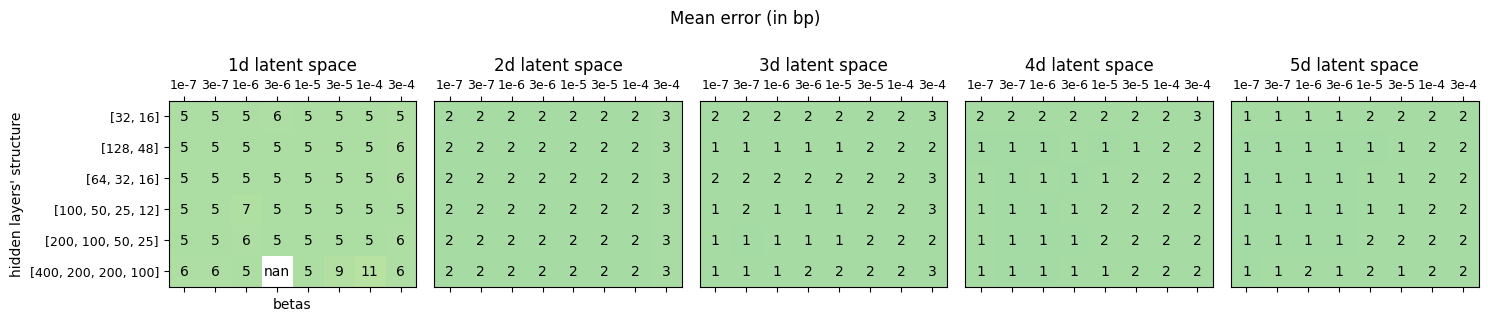

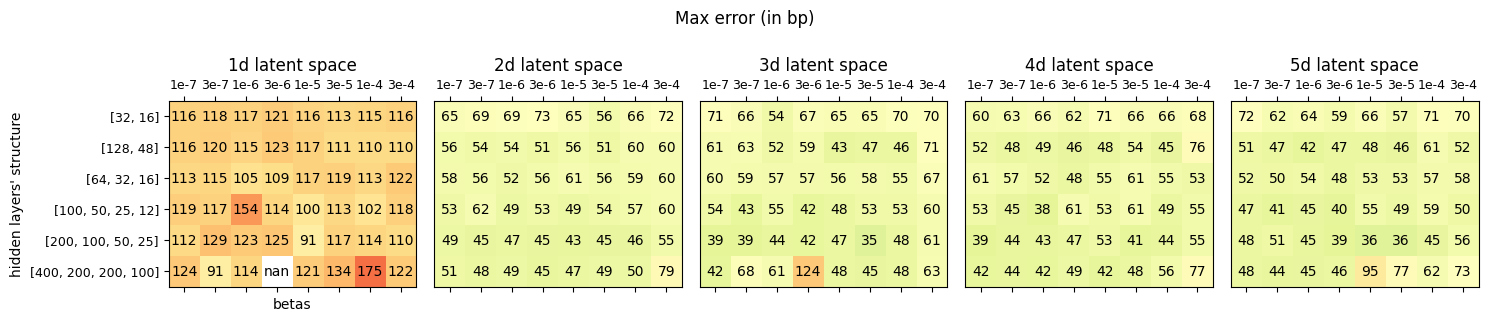

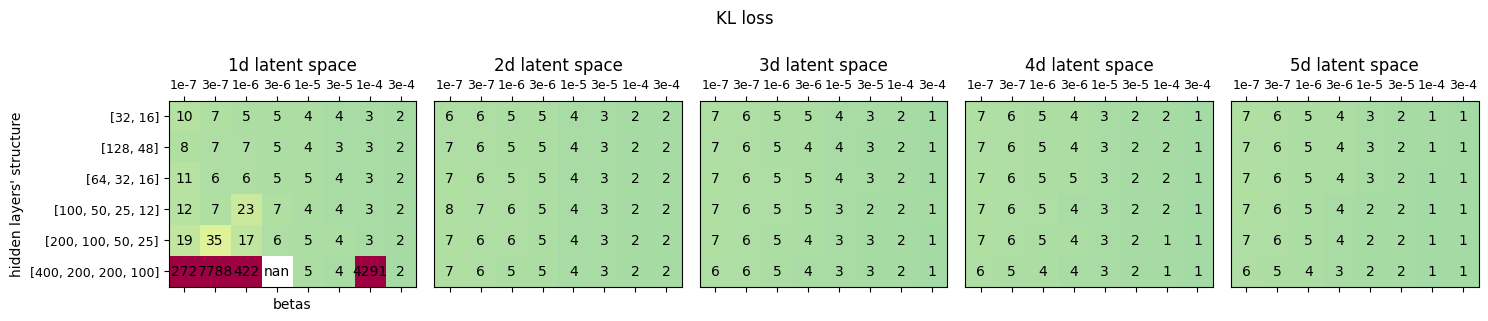

In [4]:
import matplotlib.pyplot as plt
import os
from references.global_parameters import MIN_VOL_ON_GRAPHS, MAX_VOL_ON_GRAPHS

NODES_TICK_SIZE = 9
BETAS_TICK_SIZE = 9
VALUES_SIZE = 10
FIGSIZE = (15,3.5)

save_name = 'hyperparameters_'

# MEAN ERRORS
fig = plt.figure(figsize=FIGSIZE)
fig.suptitle(f'Mean error (in bp)')

for i_d, latent_space_dim in enumerate(LATENT_SPACE_DIMS):
    
    ax = fig.add_subplot(1, len(LATENT_SPACE_DIMS), i_d + 1)  # Create a 3D subplot  
    ax.matshow(mean_errors[i_d,:,:], 
                cmap=plt.get_cmap('Spectral_r'), 
                vmin=MIN_VOL_ON_GRAPHS, 
                vmax=MAX_VOL_ON_GRAPHS)
    
    ax.set_title(f'{latent_space_dim}d latent space')
    ax.set_xticks(ticks=range(len(BETAS)), labels=BETAS, size=BETAS_TICK_SIZE)
    if i_d == 0:
        ax.set_xlabel('betas')
        ax.set_ylabel('hidden layers\' structure')
        ax.set_yticks(ticks=range(len(HIDDEN_LAYERS_NODES)), labels=HIDDEN_LAYERS_NODES, size=NODES_TICK_SIZE)
    else:
        ax.set_yticks([])

    for (x, y), value in np.ndenumerate(mean_errors[i_d,:,:]):
        ax.text(y, x, f"{value:.0f}", va="center", ha="center", color='black', size=VALUES_SIZE)
plt.tight_layout()
# Save plot
if save_name is not None:
    folder_path = '../../reports/vol/'
    file_path = os.path.join(folder_path, save_name + 'meanerror.png')
    plt.savefig(file_path)


# MAX ERRORS
fig = plt.figure(figsize=FIGSIZE)
fig.suptitle(f'Max error (in bp)')

for i_d, latent_space_dim in enumerate(LATENT_SPACE_DIMS):
    
    ax = fig.add_subplot(1, len(LATENT_SPACE_DIMS), i_d + 1)  # Create a 3D subplot  
    ax.matshow(max_errors[i_d,:,:], 
                cmap=plt.get_cmap('Spectral_r'), 
                vmin=MIN_VOL_ON_GRAPHS, 
                vmax=MAX_VOL_ON_GRAPHS)
    
    ax.set_title(f'{latent_space_dim}d latent space')
    ax.set_xticks(ticks=range(len(BETAS)), labels=BETAS, size=BETAS_TICK_SIZE)
    if i_d == 0:
        ax.set_xlabel('betas')
        ax.set_ylabel('hidden layers\' structure')
        ax.set_yticks(ticks=range(len(HIDDEN_LAYERS_NODES)), labels=HIDDEN_LAYERS_NODES, size=NODES_TICK_SIZE)
    else:
        ax.set_yticks([])
        
    for (x, y), value in np.ndenumerate(max_errors[i_d,:,:]):
        ax.text(y, x, f"{value:.0f}", va="center", ha="center", color='black', size=VALUES_SIZE)
plt.tight_layout()
if save_name is not None:
    folder_path = '../../reports/vol/'
    file_path = os.path.join(folder_path, save_name + 'maxerror.png')
    plt.savefig(file_path)


# KL LOSS
fig = plt.figure(figsize=FIGSIZE)
fig.suptitle(f'KL loss')

for i_d, latent_space_dim in enumerate(LATENT_SPACE_DIMS):
    
    ax = fig.add_subplot(1, len(LATENT_SPACE_DIMS), i_d + 1)  # Create a 3D subplot  
    ax.matshow(kl_loss[i_d,:,:], 
                cmap=plt.get_cmap('Spectral_r'), 
                vmin=MIN_VOL_ON_GRAPHS, 
                vmax=MAX_VOL_ON_GRAPHS)
    
    ax.set_title(f'{latent_space_dim}d latent space')
    ax.set_xticks(ticks=range(len(BETAS)), labels=BETAS, size=BETAS_TICK_SIZE)
    if i_d == 0:
        ax.set_xlabel('betas')
        ax.set_ylabel('hidden layers\' structure')
        ax.set_yticks(ticks=range(len(HIDDEN_LAYERS_NODES)), labels=HIDDEN_LAYERS_NODES, size=NODES_TICK_SIZE)
    else:
        ax.set_yticks([])
        
    for (x, y), value in np.ndenumerate(kl_loss[i_d,:,:]):
        ax.text(y, x, f"{value :.0f}", va="center", ha="center", color='black', size=VALUES_SIZE)
plt.tight_layout()
if save_name is not None:
    folder_path = '../../reports/vol/'
    file_path = os.path.join(folder_path, save_name + 'klloss.png')
    plt.savefig(file_path)

##### Mean values over all betas and hidden layer's structures for such metrics as "mean error", "max error" and "KL loss" against latent space dimension

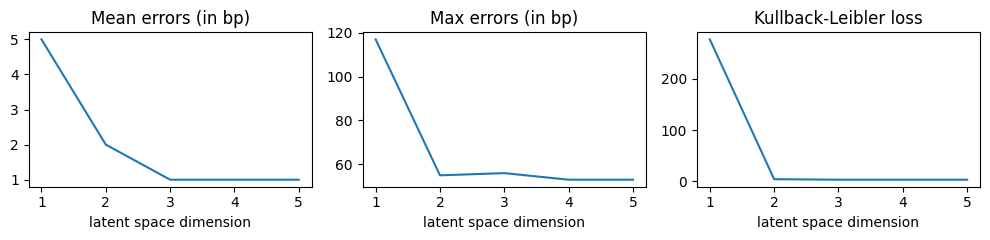

In [5]:
kl_loss_by_dim = np.zeros_like(LATENT_SPACE_DIMS)
mean_errors_by_dim = np.zeros_like(LATENT_SPACE_DIMS)
max_errors_by_dim = np.zeros_like(LATENT_SPACE_DIMS)

for i_d, dim in enumerate(LATENT_SPACE_DIMS):
    
    mean_errors_one_dim = mean_errors[i_d,:,:]
    mean_errors_by_dim[i_d] = mean_errors_one_dim[~np.isnan(mean_errors_one_dim)].mean()

    max_errors_one_dim = max_errors[i_d,:,:]
    max_errors_by_dim[i_d] = max_errors_one_dim[~np.isnan(max_errors_one_dim)].mean()

    kl_loss_one_dim = kl_loss[i_d,:,:]
    kl_loss_by_dim[i_d] = kl_loss_one_dim[~np.isnan(kl_loss_one_dim)].mean()

plt.figure(figsize=(10, 2.5))

ax1 = plt.subplot(1, 3, 1)
ax1.plot(LATENT_SPACE_DIMS, mean_errors_by_dim)
ax1.set_title('Mean errors (in bp)')
ax1.set_xlabel('latent space dimension')

ax2 = plt.subplot(1, 3, 2)
ax2.plot(LATENT_SPACE_DIMS, max_errors_by_dim)
ax2.set_title('Max errors (in bp)')
ax2.set_xlabel('latent space dimension')

ax3 = plt.subplot(1, 3, 3)
ax3.plot(LATENT_SPACE_DIMS, kl_loss_by_dim)
ax3.set_title('Kullback-Leibler loss')
ax3.set_xlabel('latent space dimension')

plt.tight_layout()

# folder_path = '../../reports/vol/'
# file_path = os.path.join(folder_path, save_name + 'latent_space_selecting.png')
# plt.savefig(file_path)

plt.show()

So, best latent space dimension is 3